In [1]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

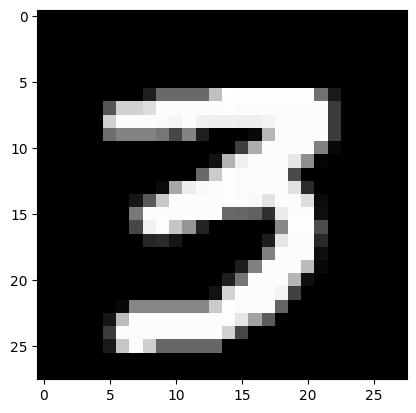

In [45]:
# define a transform to convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# download and load the training dataset
train_dataset = torchvision.datasets.MNIST(
    root='../data/hidden', 
    train=True,
    download=True,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
    num_workers=0,
    shuffle=True
)

image, _ = next(iter(train_loader))
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [75]:
class FEBAM(nn.Module):
    def __init__(self, x_dim, y_dim, learning_rate):
        super(FEBAM, self).__init__()
        self.W = nn.Linear(x_dim, y_dim)
        self.sigmoid = nn.Sigmoid()
        self.V = nn.Linear(y_dim, x_dim)
        self.lr = learning_rate
        
    def forward(self, x):
        y0 = self.sigmoid(self.W(x))
        x1 = self.sigmoid(self.V(y0))
        y1 = self.sigmoid(self.W(x1))
        return x1, y1, y0

    def update_weights(self, x0, xt, y0, yt):
        W_diff = torch.outer((y0 - yt).squeeze(), (x0 + xt).squeeze())
        V_diff = torch.outer((x0 - xt).squeeze(), (y0 + yt).squeeze())
        self.W.weight.data = self.W.weight.data + self.lr * W_diff
        self.V.weight.data = self.V.weight.data + self.lr * V_diff

In [87]:
model = FEBAM(28 * 28, 300, learning_rate = 0.01)

In [88]:
x0 = image.reshape(1, 28*28)
xt, yt, y0 = model(x0)
model.update_weights(x0, xt, y0, yt)

for _ in range(1):
    xt, yt, _ = model(xt)
    model.update_weights(x0, xt, y0, yt)

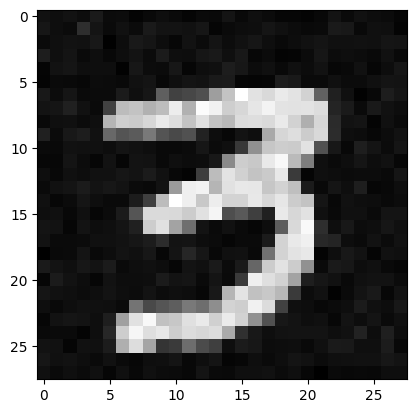

In [89]:
plt.imshow(xt.detach().numpy().reshape(28, 28), cmap='gray')
plt.show()